In [8]:
import numpy as np
import os
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import scipy.stats as stats

import re
from sklearn.preprocessing import OrdinalEncoder
from scipy.stats import kruskal
from sklearn.model_selection import cross_val_score
from matplotlib_venn import venn2
import gseapy as gp
from gseapy.plot import barplot, dotplot

from google.colab import drive
from sklearn.ensemble import RandomForestClassifier

# 1.0 Data loading

In [9]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
#parent_dir = "/Users/u0126415/Desktop/Munich_challenge"
parent_dir = '/content/drive/My Drive/Munich'
output_dir = f"{parent_dir}/output"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [11]:
df = pd.read_csv(f"{parent_dir}/test_dataset.csv")

In [12]:
df

,Samples,age,sex,outcome,ACTN1,2-Sep,4-Sep,5-Sep,6-Sep,7-Sep,...,SGTA,CTSS,SBF2,A0A8Q3SIA1,SORBS2,MSN,C2orf16,CROCC2,IGKV3-20,HKDC1
0,1,73,M,3,8.594547,8.010689,8.137037,7.039320,8.412405,8.922140,...,7.289629,7.392311,6.915355,7.829933,8.010003,8.444941,6.974797,8.319585,7.488713,8.437909126;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;...
1,2,86,M,3,7.811289,7.366123,7.029140,6.411265,7.745597,8.120255,...,8.070407,6.370630,7.767701,7.107311,6.620994,7.885333,6.218600,8.235903,6.494975,6.482591152;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;...
2,3,68,M,3,8.824900,8.237328,8.485068,7.671460,8.816692,9.158820,...,8.292811,8.137554,8.559139,8.073441,8.090716,8.866626,7.315614,8.844439,7.719174,8.63142395;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;...
3,4,90,W,3,9.113463,8.717421,8.922482,7.840937,8.993887,9.407018,...,8.375078,7.700357,9.357859,8.439145,8.805127,9.046984,8.077949,8.707314,7.482477,7.484539509;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;...
4,5,87,W,3,8.788427,8.162390,7.989939,7.444959,8.574615,9.107782,...,7.987432,7.791417,8.133678,7.469316,7.952075,8.632978,6.866069,8.624498,7.088738,7.773025513;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,74,M,3,8.081356,7.602226,6.949230,6.635944,8.075583,8.375791,...,7.746626,8.109174,8.256910,7.157194,6.712103,8.051207,6.915861,8.352385,7.127914,7.782884598;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;...
96,97,50,M,3,8.145290,7.496252,7.673852,6.647793,8.228621,8.360907,...,8.075392,6.920318,8.178977,7.488226,8.143577,8.233995,6.874346,8.589916,7.449849,6.654234886;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;...
97,98,86,W,3,8.743844,8.190084,8.209849,7.519600,8.593636,9.105433,...,8.173807,7.206778,8.151554,7.716733,8.058727,8.563765,7.171726,8.687111,7.892479,8.176785469;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;...
98,99,82,W,3,8.497725,7.928959,7.855052,7.046105,8.341894,8.815426,...,8.327461,7.271958,7.025926,7.531783,7.974064,8.437881,7.308778,8.519637,7.147552,7.744308472;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;...


## 1.1 Y distribution

In [13]:
np.unique(df["outcome"],return_counts=True)

(array([1, 2, 3, 5]), array([ 1, 16, 51, 32]))

## 1.2 Drop cases with Y as 1

In [14]:
df = df[df["outcome"] != 1]

In [15]:
np.unique(df["outcome"],return_counts=True)

(array([2, 3, 5]), array([16, 51, 32]))

# 2.0 Data cleaning

### 2.0.1 Typo in the last column

In [16]:
# there are some typo in the last column, shown below
col_typo = df.columns.to_list()[-1]
df[col_typo]

0     8.437909126;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;...
1     6.482591152;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;...
2     8.63142395;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;...
3     7.484539509;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;...
4     7.773025513;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;...
                            ...                        
95    7.782884598;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;...
96    6.654234886;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;...
97    8.176785469;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;...
98    7.744308472;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;...
99    8.309800148;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;...
Name: HKDC1, Length: 99, dtype: object

In [17]:
#The function is to handle the issue
def clean_string(input_string):
    return re.sub(r'[^0-9.]', '', input_string)

df[col_typo] = df[col_typo].apply(clean_string)
df

<ipython-input-17-caf44dc39746>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col_typo] = df[col_typo].apply(clean_string)


,Samples,age,sex,outcome,ACTN1,2-Sep,4-Sep,5-Sep,6-Sep,7-Sep,...,SGTA,CTSS,SBF2,A0A8Q3SIA1,SORBS2,MSN,C2orf16,CROCC2,IGKV3-20,HKDC1
0,1,73,M,3,8.594547,8.010689,8.137037,7.039320,8.412405,8.922140,...,7.289629,7.392311,6.915355,7.829933,8.010003,8.444941,6.974797,8.319585,7.488713,8.437909126
1,2,86,M,3,7.811289,7.366123,7.029140,6.411265,7.745597,8.120255,...,8.070407,6.370630,7.767701,7.107311,6.620994,7.885333,6.218600,8.235903,6.494975,6.482591152
2,3,68,M,3,8.824900,8.237328,8.485068,7.671460,8.816692,9.158820,...,8.292811,8.137554,8.559139,8.073441,8.090716,8.866626,7.315614,8.844439,7.719174,8.63142395
3,4,90,W,3,9.113463,8.717421,8.922482,7.840937,8.993887,9.407018,...,8.375078,7.700357,9.357859,8.439145,8.805127,9.046984,8.077949,8.707314,7.482477,7.484539509
4,5,87,W,3,8.788427,8.162390,7.989939,7.444959,8.574615,9.107782,...,7.987432,7.791417,8.133678,7.469316,7.952075,8.632978,6.866069,8.624498,7.088738,7.773025513
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,74,M,3,8.081356,7.602226,6.949230,6.635944,8.075583,8.375791,...,7.746626,8.109174,8.256910,7.157194,6.712103,8.051207,6.915861,8.352385,7.127914,7.782884598
96,97,50,M,3,8.145290,7.496252,7.673852,6.647793,8.228621,8.360907,...,8.075392,6.920318,8.178977,7.488226,8.143577,8.233995,6.874346,8.589916,7.449849,6.654234886
97,98,86,W,3,8.743844,8.190084,8.209849,7.519600,8.593636,9.105433,...,8.173807,7.206778,8.151554,7.716733,8.058727,8.563765,7.171726,8.687111,7.892479,8.176785469
98,99,82,W,3,8.497725,7.928959,7.855052,7.046105,8.341894,8.815426,...,8.327461,7.271958,7.025926,7.531783,7.974064,8.437881,7.308778,8.519637,7.147552,7.744308472


##  2.1 Ordinal Encoding

In [18]:
encoder = OrdinalEncoder()
outcome = np.array(df["outcome"])
outcome_encoded = encoder.fit_transform(outcome.reshape(-1, 1)).ravel()

In [19]:
outcome_encoded

array([1., 1., 1., 1., 1., 0., 1., 1., 0., 2., 2., 1., 2., 2., 2., 2., 0.,
       2., 2., 2., 2., 1., 1., 1., 2., 2., 1., 0., 0., 2., 2., 1., 2., 1.,
       1., 0., 1., 1., 0., 2., 1., 1., 1., 0., 2., 2., 1., 2., 2., 2., 2.,
       1., 1., 0., 1., 0., 2., 0., 1., 2., 2., 1., 0., 1., 1., 1., 1., 1.,
       1., 1., 2., 1., 2., 1., 0., 1., 2., 0., 1., 2., 2., 2., 1., 1., 1.,
       1., 1., 1., 1., 2., 1., 0., 0., 1., 1., 1., 1., 1., 1.])

# 3.0 Identification related proteomic features

In [20]:
# Here, I just listed two possible algorithms here and plotted the shared identified features between them.

In [21]:
proteomic_features = df.columns.to_list()[4:]

## 3.1 Kruskal-Wallis H-test

In [22]:
# Kruskal-Wallis H-test
p_values = []
for column in proteomic_features:
    groups = [df[column][outcome_encoded == cls] for cls in np.unique(outcome_encoded)]
    _, p = kruskal(*groups)
    p_values.append(p)

# Create a DataFrame with p-values
p_values_df = pd.DataFrame({'Variable': proteomic_features, 'p_value': p_values})

# Filter significant variables (e.g., p < 0.05)
significant_vars_KWH = p_values_df[p_values_df['p_value'] < 0.05]['Variable']
print(f"Significant variables: {significant_vars_KWH}")

Significant variables: 21         ABHD16A
36           ACOT9
47      ACTG1;ACTB
48           ACTN4
93          AKR1B1
           ...    
2191         VDAC2
2198        VPS13D
2213           VWF
2238         YWHAG
2244       ZC3HAV1
Name: Variable, Length: 140, dtype: object


In [23]:
len(significant_vars_KWH)

140

## 3.2 Random Forest Classifier

In [24]:
# RandomForestClassifier to get feature importances
model = RandomForestClassifier(n_estimators=100, random_state=0)
model.fit(df[proteomic_features], outcome_encoded)

# Get feature importances
feature_importances = pd.DataFrame({'Variable': proteomic_features, 'Importance': model.feature_importances_})

# Select top features based on importance
top_features = feature_importances.sort_values(by='Importance', ascending=False).head(len(significant_vars_KWH))
significant_vars_RF = feature_importances[feature_importances['Importance'] != 0]["Variable"]    #The threshold can be optimized to a proper number of features.

print(f"Non-zero features based on importance: {significant_vars_RF}")

# Cross-validation to evaluate model performance with selected features
#selected_features = top_features['Variable']
X_selected = df[significant_vars_RF]

# Cross-validation
cv_scores = cross_val_score(model, X_selected, outcome_encoded, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")


Non-zero features based on importance: 1          2-Sep
2          4-Sep
3          5-Sep
4          6-Sep
9            A2M
          ...   
2279        CUL1
2282        NONO
2283        SGTA
2291    IGKV3-20
2292       HKDC1
Name: Variable, Length: 1031, dtype: object
Cross-validation scores: [0.55       0.4        0.7        0.55       0.42105263]
Mean cross-validation score: 0.5242105263157895


## 3.3 Venn plot to show shared features

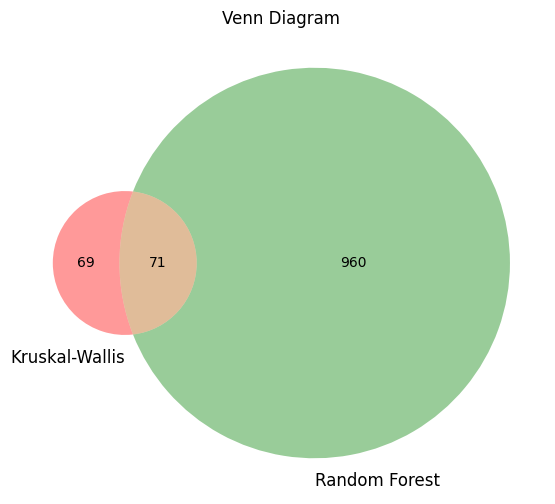

In [25]:
plt.figure(figsize=(8, 6))
venn2([set(significant_vars_KWH), set(significant_vars_RF)], ('Kruskal-Wallis', 'Random Forest'))
plt.title('Venn Diagram')
plt.show()

In [26]:
significant_vars_common = set(significant_vars_KWH) & set(significant_vars_RF)
significant_vars_common

{'ACOT9',
 'AKR1B1',
 'ARF6',
 'ARHGAP18',
 'ARPC4-TTLL3;ARPC4',
 'ATP5A1',
 'ATP5B',
 'ATP5H',
 'ATP6V0D1',
 'BRK1',
 'C1QBP',
 'C6',
 'CALM2;CALM3;CALM1',
 'CALU',
 'CD9',
 'CLTA',
 'CLU',
 'CORO1B',
 'COX5A',
 'CPT2',
 'CTSC',
 'DDX6',
 'DOK2',
 'DSTN',
 'ERP44',
 'ETFB',
 'GNAS',
 'GRAP2',
 'GYG1',
 'HECTD3',
 'HEL-S-117;ADH1B;ADH1A',
 'HSPE1',
 'ITGA2B',
 'KIF4B',
 'KRT77',
 'LRPPRC',
 'LSM3',
 'MAN2A2',
 'MAOB',
 'MDH2',
 'MRGPRG',
 'MT-CO2',
 'MYL6',
 'NNT',
 'NRK',
 'OGDH',
 'PIP4K2B',
 'PMVK',
 'PODN',
 'PPP3CA',
 'PSM8;PSMB8',
 'PTBP1',
 'RASGRP2',
 'RELN',
 'RPS18',
 'RRAS',
 'SHANK3',
 'SLC25A1',
 'SSFA2',
 'TAGLN2',
 'TGFB1',
 'THBS1',
 'TMX1',
 'TPM2b',
 'TPM3',
 'USP32',
 'VAPA',
 'VDAC2',
 'VWF',
 'YWHAG',
 'ZC3HAV1'}

In [27]:
#extend the list with synonyms
significant_vars_common_ext = [item for sublist in significant_vars_common for item in sublist.split(';')]


# 4.0 Pathway mapping

In [28]:
#Initially, we mapped overlapping identified feature from both algorithms

    Gene_set                                          Term Overlap  \
0  KEGG_2016   Amphetamine addiction Homo sapiens hsa05031    6/67   
1  KEGG_2016     Alzheimer's disease Homo sapiens hsa05010   8/168   
2  KEGG_2016  Rap1 signaling pathway Homo sapiens hsa04015   8/211   
3  KEGG_2016         Renin secretion Homo sapiens hsa04924    5/64   
4  KEGG_2016    Dopaminergic synapse Homo sapiens hsa04728   6/129   

        P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  \
0  2.211835e-07          0.000020            0                     0   
1  2.696511e-07          0.000020            0                     0   
2  1.514716e-06          0.000077            0                     0   
3  4.734366e-06          0.000180            0                     0   
4  1.044045e-05          0.000317            0                     0   

   Odds Ratio  Combined Score  \
0   27.516047      421.663426   
1   14.321014      216.621625   
2   11.262940      150.926579   
3   23.380414 

<Axes: title={'center': 'KEGG Pathway Enrichment Analysis'}, xlabel='$- \\log_{10}$ (Adjusted P-value)'>

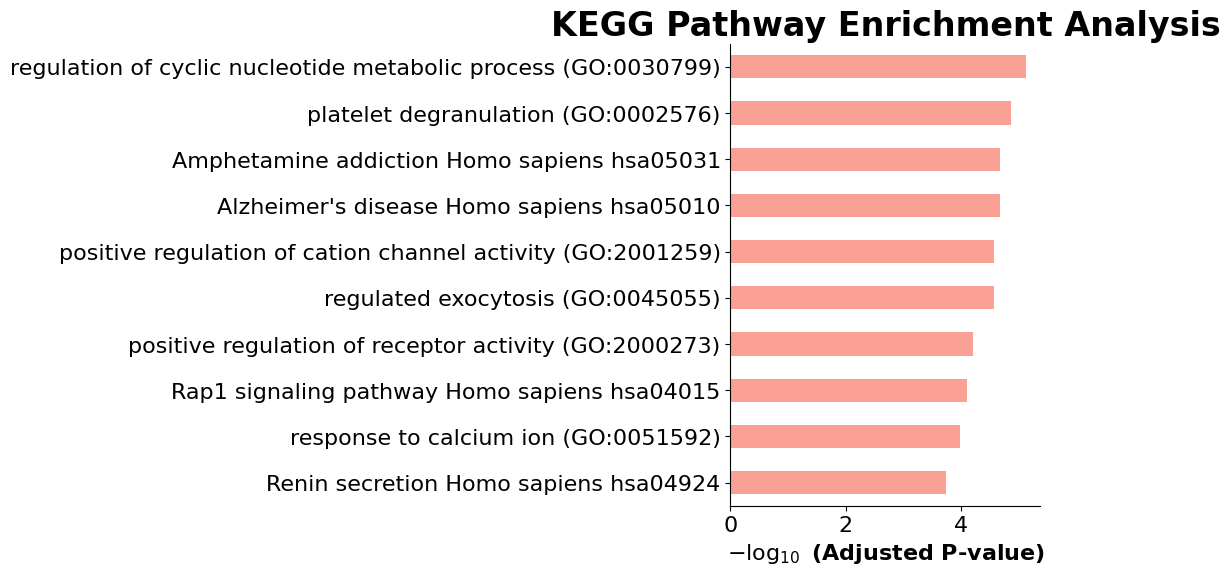

In [29]:

# Perform Enrichment Analysis
enr = gp.enrichr(gene_list=significant_vars_common_ext,
                 gene_sets=['KEGG_2016', 'GO_Biological_Process_2018'],
                 organism='human',  # Ensure the organism is correctly specified
                 outdir='test/enrichr_kegg',  # Save your results
                 cutoff=0.05  # Only significant results
                 )

# Display results
print(enr.results.head())

# Visualize the enrichment results
barplot(enr.results, title='KEGG Pathway Enrichment Analysis')

In [32]:
significant_vars_common

{'ACOT9',
 'AKR1B1',
 'ARF6',
 'ARHGAP18',
 'ARPC4-TTLL3;ARPC4',
 'ATP5A1',
 'ATP5B',
 'ATP5H',
 'ATP6V0D1',
 'BRK1',
 'C1QBP',
 'C6',
 'CALM2;CALM3;CALM1',
 'CALU',
 'CD9',
 'CLTA',
 'CLU',
 'CORO1B',
 'COX5A',
 'CPT2',
 'CTSC',
 'DDX6',
 'DOK2',
 'DSTN',
 'ERP44',
 'ETFB',
 'GNAS',
 'GRAP2',
 'GYG1',
 'HECTD3',
 'HEL-S-117;ADH1B;ADH1A',
 'HSPE1',
 'ITGA2B',
 'KIF4B',
 'KRT77',
 'LRPPRC',
 'LSM3',
 'MAN2A2',
 'MAOB',
 'MDH2',
 'MRGPRG',
 'MT-CO2',
 'MYL6',
 'NNT',
 'NRK',
 'OGDH',
 'PIP4K2B',
 'PMVK',
 'PODN',
 'PPP3CA',
 'PSM8;PSMB8',
 'PTBP1',
 'RASGRP2',
 'RELN',
 'RPS18',
 'RRAS',
 'SHANK3',
 'SLC25A1',
 'SSFA2',
 'TAGLN2',
 'TGFB1',
 'THBS1',
 'TMX1',
 'TPM2b',
 'TPM3',
 'USP32',
 'VAPA',
 'VDAC2',
 'VWF',
 'YWHAG',
 'ZC3HAV1'}

In [35]:
#export common features for online tools
df_common_feature = pd.DataFrame(list(significant_vars_common),columns = ["features"])
df_common_feature

,features
0,MYL6
1,GNAS
2,THBS1
3,TPM3
4,MT-CO2
...,...
66,ARHGAP18
67,TGFB1
68,CORO1B
69,ATP5H


In [37]:
df_common_feature.to_excel(f"{parent_dir}/common_features.xlsx")
#be aware that some feature names are with synonym like "aa;bb;cc"